In [9]:
!pip install langgraph==0.2.74 langchain_community==0.3.18 langchain-openai==0.3.7 langchain-core==0.3.40 python-dotenv typing_extensions openai==1.64.0

  Using cached langchain_openai-0.3.7-py3-none-any.whl (55 kB)
  Using cached openai-1.64.0-py3-none-any.whl (472 kB)
  Using cached tiktoken-0.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
  Using cached jiter-0.8.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (345 kB)
  Using cached regex-2024.11.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (781 kB)

[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [10]:
import os
import json
import re
from typing import List, Dict  # Permanece igual
from typing_extensions import TypedDict  # Corrige TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from langchain_openai.chat_models import ChatOpenAI
from IPython.display import display, HTML, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain.schema import SystemMessage, HumanMessage

# Carregar variáveis de ambiente
load_dotenv()

# Definir a chave da API
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Inicializar o modelo de linguagem
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Definir a estrutura de dados do candidato
class Candidate(TypedDict):
    name: str
    resume: str
    skills: List[str]
    experience: int
    education_level: str
    score: float
    feedback: str

# Definir o estado do fluxo de trabalho
class State(TypedDict):
    candidates: List[Candidate]
    job_requirements: Dict[str, any]
    result: str

def extract_information_from_resume(resume_text: str) -> Dict:
    """Extrai informações do currículo usando regex."""
    info = {}
    
    # Extrair nome
    name_match = re.search(r'Nome:\s*(.*?)(?:\n|$)', resume_text)
    info['name'] = name_match.group(1).strip() if name_match else ''
    
    # Extrair experiência
    exp_match = re.search(r'(\d+)\s*anos? de experiência', resume_text)
    info['experience'] = int(exp_match.group(1)) if exp_match else 0
    
    # Extrair educação
    edu_patterns = [
        r'graduação em ([^\.]*)',
        r'formad[ao] em ([^\.]*)',
        r'mestrado em ([^\.]*)'
    ]
    info['education_level'] = ''
    for pattern in edu_patterns:
        edu_match = re.search(pattern, resume_text, re.IGNORECASE)
        if edu_match:
            info['education_level'] = edu_match.group(1).strip()
            break
    
    # Extrair habilidades
    skills = []
    skill_patterns = [
        r'proficiente em ([^\.]*)',
        r'conhecimento em ([^\.]*)',
        r'especialista em ([^\.]*)',
        r'experiência (?:com|em) ([^\.]*)'
    ]
    for pattern in skill_patterns:
        skill_match = re.search(pattern, resume_text, re.IGNORECASE)
        if skill_match:
            skills.extend([s.strip() for s in skill_match.group(1).split(',')])
            skills.extend([s.strip() for s in skill_match.group(1).split(' e ')])
    
    info['skills'] = list(set(skills))  # Remove duplicatas
    return info

def extract_information(state: State) -> State:
    """Extrai informações dos currículos."""
    updated_candidates = []
    
    for candidate in state['candidates']:
        try:
            info = extract_information_from_resume(candidate['resume'])
            candidate.update({
                'name': info['name'],
                'skills': info['skills'],
                'experience': info['experience'],
                'education_level': info['education_level'],
                'score': 0.0,
                'feedback': ''
            })
        except Exception as e:
            print(f"Erro ao extrair informações: {e}")
        
        updated_candidates.append(candidate)
    
    state['candidates'] = updated_candidates
    return state

In [11]:
def evaluate_candidate(state: State) -> State:
    """Avalia os candidatos com base nos requisitos."""
    updated_candidates = []
    
    for candidate in state['candidates']:
        try:
            # Sistema de pontuação direto
            score = 0
            feedback_points = []
            
            # Avaliar habilidades (4 pontos)
            required_skills = state['job_requirements']['skills_required']
            matching_skills = []
            for req_skill in required_skills:
                for candidate_skill in candidate['skills']:
                    if req_skill.lower() in candidate_skill.lower():
                        matching_skills.append(req_skill)
                        break
            
            skill_score = len(set(matching_skills)) / len(required_skills) * 4
            score += skill_score
            feedback_points.append(f"Possui {len(set(matching_skills))} de {len(required_skills)} habilidades requeridas")
            
            # Avaliar experiência (3 pontos)
            min_exp = state['job_requirements']['minimum_experience']
            if candidate['experience'] >= min_exp:
                score += 3
                feedback_points.append(f"Experiência adequada ({candidate['experience']} anos)")
            else:
                feedback_points.append(f"Experiência abaixo do requisito ({candidate['experience']} anos)")
            
            # Avaliar educação (3 pontos)
            if candidate['education_level']:
                score += 3
                feedback_points.append(f"Possui formação adequada: {candidate['education_level']}")
            
            # Atualizar candidato
            candidate['score'] = min(score, 10)  # Limita a 10 pontos
            candidate['feedback'] = ". ".join(feedback_points)
            
        except Exception as e:
            candidate['score'] = 0.0
            candidate['feedback'] = f"Erro na avaliação: {str(e)}"
        
        updated_candidates.append(candidate)
    
    state['candidates'] = updated_candidates
    return state

def rank_candidates(state: State) -> State:
    """Classifica os candidatos por pontuação."""
    try:
        state['candidates'].sort(key=lambda x: (float(x.get('score', 0)), x.get('experience', 0)), reverse=True)
    except Exception as e:
        print(f"Erro ao classificar candidatos: {e}")
    return state

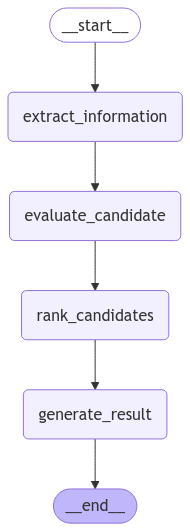

**RELATÓRIO DE CLASSIFICAÇÃO DE CANDIDATOS**

**Requisitos da Vaga:**
- Habilidades: Python, SQL, Desenvolvimento Web
- Experiência Mínima: 3 anos
- Educação: Graduação em área relacionada
- Atributos Desejados: Trabalho em equipe, Metodologias Ágeis

**MELHOR CANDIDATO:**
- Nome: Maria Silva
- Pontuação: 8.7/10
- Experiência: 5 anos
- Educação: Ciência da Computação
- Habilidades: Python, JavaScript, experiência com bancos de dados SQL
- Feedback: Possui 2 de 3 habilidades requeridas. Experiência adequada (5 anos). Formação adequada: Ciência da Computação.

**RANKING COMPLETO:**
1. Maria Silva - Pontuação: 8.7/10
2. João Souza - Pontuação: 6.0/10
3. Ana Pereira - Pontuação: 4.3/10

**Colocação dos Candidatos:**
- 1ª Colocação: Maria Silva
- 2ª Colocação: João Souza
- 3ª Colocação: Ana Pereira


In [19]:
def generate_result(state: State) -> State:
    """Gera o relatório final."""
    try:
        if not state['candidates']:
            state['result'] = 'Não há candidatos para avaliar.'
            return state

        report = []
        report.append("=== RELATÓRIO DE CLASSIFICAÇÃO DE CANDIDATOS ===\n")
        
        # Requisitos da vaga
        report.append("Requisitos da Vaga:")
        report.append(f"- Habilidades: {', '.join(state['job_requirements']['skills_required'])}")
        report.append(f"- Experiência Mínima: {state['job_requirements']['minimum_experience']} anos")
        report.append(f"- Educação: {state['job_requirements']['education_level']}")
        report.append(f"- Atributos Desejados: {', '.join(state['job_requirements']['desired_attributes'])}\n")
        
        # Melhor candidato
        best_candidate = state['candidates'][0]
        report.append("MELHOR CANDIDATO:")
        report.append(f"Nome: {best_candidate.get('name', 'Nome não disponível')}")
        report.append(f"Pontuação: {best_candidate.get('score', 0):.1f}/10")
        report.append(f"Experiência: {best_candidate.get('experience', 0)} anos")
        report.append(f"Educação: {best_candidate.get('education_level', 'Não informado')}")
        report.append(f"Habilidades: {', '.join(best_candidate.get('skills', []))}")
        report.append(f"Feedback: {best_candidate.get('feedback', 'Sem feedback disponível')}\n")
        
        # Ranking completo
        report.append("RANKING COMPLETO:")
        for i, candidate in enumerate(state['candidates'], 1):
            report.append(f"{i}. {candidate.get('name', f'Candidato {i}')} - Pontuação: {candidate.get('score', 0):.1f}/10")
        
        role_prompt = """
        Você agora é um profissional de RH com mais de 20 anos de experiência, altamente capacitado e com um profundo entendimento das dinâmicas organizacionais e das práticas de gestão de pessoas. 
        Ao longo da sua carreira, você desenvolveu habilidades em recrutamento e seleção, treinamento e desenvolvimento, gestão de desempenho, além de lidar com questões trabalhistas e de conformidade. 
        Sua experiência abrange desde a implementação de estratégias de recursos humanos alinhadas aos objetivos organizacionais até a gestão de mudanças em ambientes corporativos em constante evolução. 
        Você também é capaz de liderar equipes, promover uma cultura organizacional positiva e utilizar ferramentas tecnológicas para otimizar processos, sendo um parceiro estratégico na construção 
        de uma equipe de alto desempenho.
        """
        instruction = f"Descreva o feedback em português brasileiro:\n{report}\n coloque no final a colocação dos candidatos"
        input_text = role_prompt + "\n" + instruction
        response = llm.invoke(input_text)
        state['result'] = response.content.strip()
    except Exception as e:
        state['result'] = f"Erro ao gerar relatório: {str(e)}"
    
    return state

# Construir o workflow
workflow = StateGraph(State)

# Adicionar nós
workflow.add_node("extract_information", extract_information)
workflow.add_node("evaluate_candidate", evaluate_candidate)
workflow.add_node("rank_candidates", rank_candidates)
workflow.add_node("generate_result", generate_result)

# Definir as arestas
workflow.add_edge(START, "extract_information")
workflow.add_edge("extract_information", "evaluate_candidate")
workflow.add_edge("evaluate_candidate", "rank_candidates")
workflow.add_edge("rank_candidates", "generate_result")
workflow.add_edge("generate_result", END)

# Compilar o grafo
app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

def process_candidates(candidates: List[Candidate], job_requirements: Dict[str, any]) -> str:
    """Processa os candidatos e retorna o resultado."""
    try:
        initial_state = State(
            candidates=candidates,
            job_requirements=job_requirements,
            result=""
        )
        
        final_state = app.invoke(initial_state)
        return final_state.get('result', 'Erro: Resultado não disponível')
    except Exception as e:
        return f"Erro durante o processamento: {str(e)}"

# Exemplo de uso
if __name__ == "__main__":
    # Exemplo de candidatos
    candidates = [
        {
            "resume": """
            Nome: Maria Silva
            
            Maria é desenvolvedora de software com 5 anos de experiência. 
            Ela é proficiente em Python, JavaScript e tem experiência com bancos de dados SQL. 
            Possui graduação em Ciência da Computação.
            Trabalhou em projetos de desenvolvimento web e está familiarizada com metodologias ágeis.
            """
        },
        {
            "resume": """
            Nome: João Souza
            
            João é engenheiro de software com 8 anos de experiência. 
            Especialista em Java e C++. 
            Possui mestrado em Engenharia de Software.
            Tem experiência em liderança de equipes e desenvolvimento de sistemas de grande escala.
            """
        },
        {
            "resume": """
            Nome: Ana Pereira
            
            Ana é recém-formada em Sistemas de Informação. 
            Possui conhecimento em Python, HTML e CSS. 
            Participou de projetos acadêmicos relacionados a desenvolvimento web.
            Está em busca de sua primeira oportunidade profissional.
            """
        }
    ]

    # Requisitos da vaga
    job_requirements = {
        "skills_required": ["Python", "SQL", "Desenvolvimento Web"],
        "minimum_experience": 3,
        "education_level": "Graduação em área relacionada",
        "desired_attributes": ["Trabalho em equipe", "Metodologias Ágeis"]
    }

    # Processar os candidatos
    result = process_candidates(candidates, job_requirements)
    print(result)